In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import env

In [7]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [11]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [12]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')


In [13]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


### Detecting Anomalies in Discrete Variables

We can easily see some anomalies around IP addresses.

To detect anomalies in discrete variables we can look at two ways of summarizing the variable:
- Count: # of times each unique value appears in the dataset.
- Frequency: # of times each unique value appears in the dataset as a percentage of the total.

#### Both of the above can be found with the .value_counts method.

In [14]:
df.ip.value_counts().head()

97.105.19.58      12000
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [15]:
df.ip.value_counts(normalize=True).head()


97.105.19.58      0.858246
173.173.113.51    0.075740
72.181.113.170    0.043842
72.181.105.81     0.017594
68.201.219.223    0.001502
Name: ip, dtype: float64

In [16]:
# Create a function that combines the two.

def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


In [17]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()


,count,proba
97.105.19.58,12000,0.858246
173.173.113.51,1059,0.075740
72.181.113.170,613,0.043842
72.181.105.81,246,0.017594
68.201.219.223,21,0.001502


<AxesSubplot:>

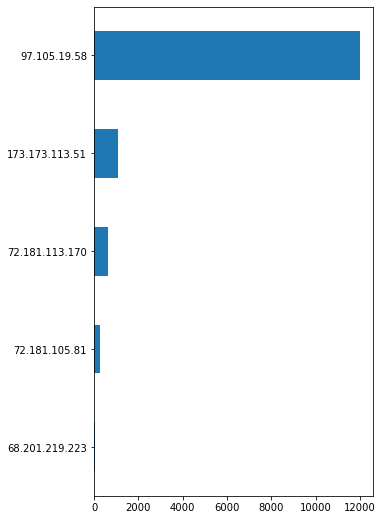

In [19]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

# Here can clearyl see the anomaly 

### Conditional Probabilities: Probabilities using 2 discrete variables

- If we are looking for an unexpected status from a known/common IP address.

In [20]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()


,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [21]:
status_given_ip[status_given_ip.status_code != '200']


,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [22]:
df[df.ip == '97.105.15.120']


,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [23]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]


,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


In [25]:
# drop the size column
df.drop(columns= 'size', inplace = True)

In [26]:
df.head()

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,python-requests/2.21.0,0.488246


In [27]:
df.describe()

,size_mb
count,13982.000000
mean,0.429252
std,0.154721
min,0.000000
25%,0.477445
50%,0.486506
75%,0.487605
max,1.961066


### Detecting Anomalies in Discrete Variables

#### Finding anomalies in already existing data:
- How many times a value of variable shows up.
- Calculate probability for each IP.

In [28]:
# how many unique ips we have in the dataset?
df.ip.nunique()

22

In [29]:
# get the counts of ips in the dataset

ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [30]:
ip_df.head()

,ip,ip_count
0,97.105.19.58,12000
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [31]:
# calculate probabity for each ip 

# ip_prob = count for each ip / total count in the dataframe

ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858246
1,173.173.113.51,0.075740
2,72.181.113.170,0.043842
3,72.181.105.81,0.017594
4,68.201.219.223,0.001502


In [32]:
# merge the two data frames create above into a single one:
ip_df = ip_df.merge(ip_df2)

ip_df

,ip,ip_count,ip_proba
0,97.105.19.58,12000,0.858246
1,173.173.113.51,1059,0.075740
2,72.181.113.170,613,0.043842
3,72.181.105.81,246,0.017594
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,95.31.16.121,2,0.000143
8,95.31.18.119,2,0.000143
9,97.105.15.120,2,0.000143


In [33]:
# look at rows where ip_proba is less than 0.01
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,95.31.16.121,2,0.000143
8,95.31.18.119,2,0.000143
9,97.105.15.120,2,0.000143
10,52.87.230.102,2,0.000143
11,35.175.171.137,2,0.000143
12,35.174.209.2,1,0.000072
13,3.92.201.136,1,0.000072


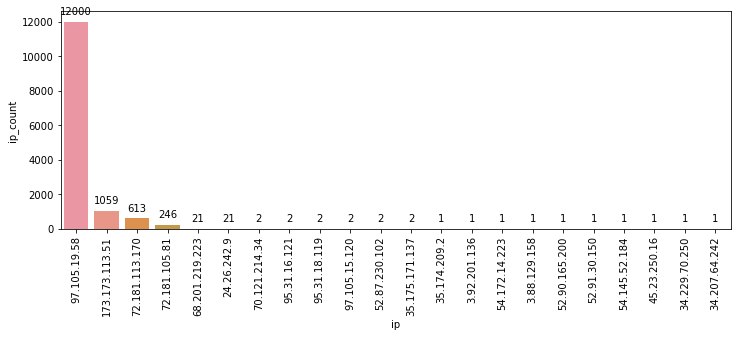

In [34]:
# plot the ip_count for each ip

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives.

#### Establish Baseline:

In [35]:
# #establish baseline 

train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [36]:
train.head()

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,python-requests/2.21.0,0.488246


In [37]:
train.size /df.size

0.9994278357888714

In [38]:
# Compute probabilities based on train sample:

ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [39]:
ip_df.shape

(19, 2)

In [40]:
df.shape

(13982, 7)

In [41]:
# Merge probabilities with all data (train + new data):

# Where the IP address is new, i.e. not seen in the training 
#  dataset, fill the probability with a value of 0.

df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.tail()

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb,ip_proba
timestamp,,,,,,,,
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,python-requests/2.21.0,1.961066,0.858595
2019-04-21 10:02:41,95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,python-requests/2.21.0,1.099591,0.000000
2019-04-17 19:36:41,95.31.16.121,GET,/api/v1/sales?page=79/,HTTP/1.1,301,python-requests/2.21.0,0.000958,0.000000
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,python-requests/2.21.0,0.002441,0.000000
2019-04-19 19:42:41,97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,python-requests/2.21.0,1.961066,0.858595


### Conditional Probablities: Probabilites using 2 discrete variables

#### Probablity of status given IP address:

In [ ]:
#Conditional probability. Probability of A given B

#  prob(A|B) = prob(A & B) / prob(B)

In [43]:
Pb = train.groupby('ip').size().div(len(train))
Pab = train.groupby(['ip', 'status_code']).\
                               size().div(len(train))


Pab.div(Pb, axis = 0, level = 'ip' )

ip              status_code
173.173.113.51  200            1.000000
24.26.242.9     200            1.000000
3.88.129.158    200            1.000000
3.92.201.136    200            1.000000
34.207.64.242   200            1.000000
34.229.70.250   200            1.000000
35.174.209.2    200            1.000000
35.175.171.137  200            1.000000
45.23.250.16    200            1.000000
52.87.230.102   200            1.000000
52.90.165.200   200            1.000000
52.91.30.150    200            1.000000
54.145.52.184   200            1.000000
54.172.14.223   200            1.000000
68.201.219.223  200            1.000000
70.121.214.34   200            1.000000
72.181.105.81   200            1.000000
72.181.113.170  200            0.996737
                499            0.003263
97.105.19.58    200            0.998833
                499            0.001167
dtype: float64

In [44]:
# calculate prob for each ip in train (Same as Pb above)

ip_probs = train.groupby('ip').size().div(len(train))

ip_probs

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [46]:
# Conditional probability. Given an ip address, what is prob of a particular status
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status_code']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_ip'})
                              )

status_given_ip

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [48]:
# calculate count for each combination of ip and status
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status_code'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'ip_status_count'}))

# merge ip_status_count with status_given_ip dataframe

ip_status = status_given_ip.merge(ip_status_count)

In [49]:
ip_status

,ip,status_code,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000000,1059
1,24.26.242.9,200,1.000000,21
2,3.88.129.158,200,1.000000,1
3,3.92.201.136,200,1.000000,1
4,34.207.64.242,200,1.000000,1
5,34.229.70.250,200,1.000000,1
6,35.174.209.2,200,1.000000,1
7,35.175.171.137,200,1.000000,2
8,45.23.250.16,200,1.000000,1
9,52.87.230.102,200,1.000000,2


In [51]:
# Add in probabilties to original events to detect anomalous events:

df = df.reset_index().merge(ip_status, on=['ip', 'status_code'], how='left').fillna(value=0).set_index('timestamp')

df.head(5)

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,python-requests/2.21.0,0.488753,0.858595,0.998833,11984.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,python-requests/2.21.0,0.003396,0.858595,0.998833,11984.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,python-requests/2.21.0,0.486472,0.858595,0.998833,11984.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,python-requests/2.21.0,0.486377,0.858595,0.998833,11984.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,python-requests/2.21.0,0.488246,0.858595,0.998833,11984.0


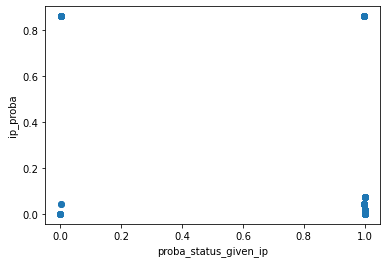

In [52]:
# plot the probabilities

plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.xlabel('proba_status_given_ip')
plt.ylabel('ip_proba');

In [53]:
df[(df['proba_status_given_ip'] > 0.8) & (df['ip_proba'] < 0.2)]

,ip,request_method,request_path,http_version,status_code,user_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET,/,HTTP/1.1,200,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,0.000072,1.0,1.0
2019-04-16 19:39:15,52.90.165.200,GET,/favicon.ico,HTTP/1.1,200,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:32,3.88.129.158,GET,/api/v1/items,HTTP/1.1,200,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,0.000072,1.0,1.0
2019-04-16 19:40:33,34.207.64.242,GET,/favicon.ico,HTTP/1.1,200,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:36,54.172.14.223,GET,/api/v1/,HTTP/1.1,200,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,0.000072,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:07,24.26.242.9,GET,/api/v1/sales?page=1,HTTP/1.1,200,python-requests/2.21.0,0.471025,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET,/api/v1/items?page=1,HTTP/1.1,200,python-requests/2.21.0,0.003396,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET,/api/v1/stores?page=1,HTTP/1.1,200,python-requests/2.21.0,0.001266,0.001503,1.0,21.0
